# **Using Machine Learning to Predict Tesla Stock Prices**
---
---


## Step 1. Import Tesla stock data
---
### **Description:**
- Used `yfinance` to fetch five years worth of stock data
- used `pandas` to arrange the data and data frames

In [1]:
import yfinance as yf
import pandas as pd

# Download Tesla stock data
df = yf.download("TSLA", start="2020-01-01", end="2025-03-13")

# Check at what the data looks like make sure it looks right
print(df.head())
print(df.tail(10))

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


## Step 2. Exploratory Data Analysis
---

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot Tesla’s closing price
plt.figure(figsize=(10, 5))
plt.plot(df["Close"])
plt.title("Tesla Stock Price Over Time 2020-Present")
plt.xlabel("Year")
plt.ylabel("Closing Price")
plt.show()

## Step 4: Feature Engineering
---
### **Description:**
#### Here I create features so the machine learning model can make predictions

1. Created “Previous_Close” → The closing price from the previous day.
2. Removed missing values caused by shifting data.
3. Defined X (features) and y (target variable) for the machine learning model.

In [2]:
# Remove 'Daily_Change' to avoid target leakage
df["Previous_Close"] = df["Close"].shift(1)
df.dropna(inplace=True)

# Define features and target variable
X = df[["Previous_Close"]]  # Only use previous day's close
y = df["Close"]

## Step 5. Splitting the Data
---
### **Description:**
- The training date size will be 80% and test size 20%. It will be randomized.

> **Why shuffle:**
- ensures that we do not randomly mix the data before splitting into training and testing sets.
- This is important for time series data like stock prices because:
  - Stock prices follow a time-based sequence.
  - If we randomly shuffle, we might have future prices appearing in the training set while trying to predict past prices, which is unrealistic.

In [3]:
from sklearn.model_selection import train_test_split
# Split the data correctly
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)  # Ensure no data leakage


## Step 6: Training a Machine Learning Model: Linear Regression
---
- simple linear regression with training data:

$$y=m x+b$$
- this is then used to predict with test data:

$$y_{pred}=m x_{test} +b$$


In [4]:
from sklearn.linear_model import LinearRegression

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

LinearRegression()

## Step 7. evaluate the model
---
### **Description**
- I will take a look at a couple values of the cost functions

The goals of these metrics are:

- How far our predictions are from the actual stock prices.
- Whether the model is making large mistakes.
- Whether our model is biased or overfitting

**MAE**
- MAE simply measures the average absolute error, meaning how far our predictions are from the actual values without considering direction.

$$
MAE = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
$$
---
**MSE**
- Similar to MAE, but instead of taking the absolute difference, we square the errors.
- Squaring amplifies larger errors, making them more important.

$$
MAE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)
$$
---

**RMSE**

- RMSE is just the square root of the MSE.
- Since MSE gives us squared values, RMSE brings it back to the same units as the original data (stock prices in dollars).

$$ RMSE = \sqrt{MSE} $$

In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

Mean Absolute Error: 7.959912037014207
Mean Squared Error: 126.76147622511183
Root Mean Squared Error: 11.258839914711988


## Step 8. Visualizing the Predictions Compared to the Actual
---
### **Description:**
- The chart is looking at test days only. Based on the training data, prediction was made
- evidence for how well to model works

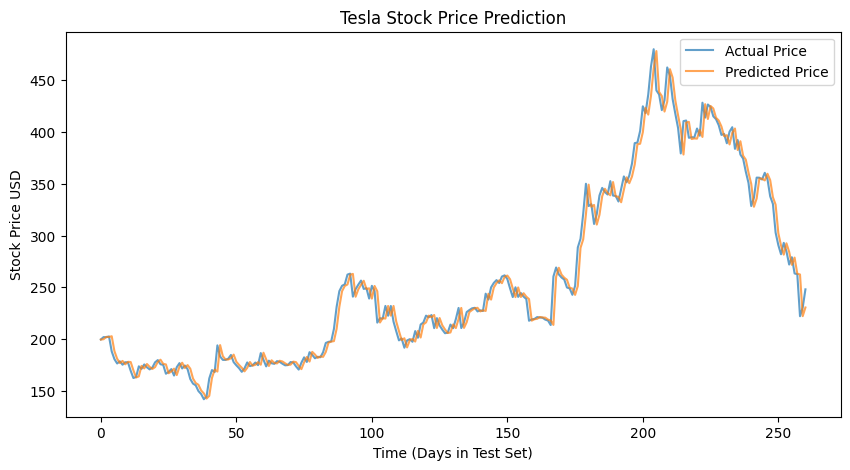

In [8]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label="Actual Price", alpha=0.7)
plt.plot(y_pred, label="Predicted Price", alpha=0.7)
plt.legend()
plt.xlabel("Time (Days in Test Set)")
plt.ylabel("Stock Price USD")
plt.title("Tesla Stock Price Prediction")
plt.show()
# Here we are looking at the test days only. based on the training data, a prediction was made

## Conclusions
---
**What do Error Metrics tell us:**
- MAE: 7.96
  - On average, our predictions are $7.96 off from actual values.

- RMSE = 11.26
  - The typical prediction error is about $11.26.

**Overall, the average error was approx $7-11**
** Model

**Based on the plot, the model does a relatively good job at predicting the trend with minimal error.**

## Debugging an Issue in the Model
---
- there was an issue prior to having all error metrics = 0
- originally was using LR with two input variables as shown below:

```
df["Previous_Close"] = df["Close"].shift(1)

df["Daily_Change"] = df["Close"] - df["Previous_Close"]

df.dropna(inplace=True) #this method cleans up the data after the dot shift method which left the first value empty

# Define features and target variable
X = df[["Previous_Close", "Daily_Change"]]
y = df["Close"]
```
- However, due to `Daily_Change` being derived from Close price, there might been an issue with it perfectly mapping (perfect overfitting). The training data is leaking into the test set
- Basically the model was cheating!
- I did a test to check if the outputs (y) where identical, if they are then it seems overfitting is the case.

```
print("y_test:", y_test[:10])
print("y_pred:", y_pred[:10])
```
- this gave the following:

```
y_test: Date
2024-08-30    214.110001
2022-01-18    343.503326
2023-05-10    168.539993
2023-11-20    235.600006
2024-08-26    213.210007
2023-06-07    224.570007
2020-12-15    211.083328
2022-12-12    167.820007
2020-03-18     24.081333
2024-03-18    173.800003
Name: Close, dtype: float64
y_pred: [214.11000061 343.50332642 168.53999329 235.6000061  213.21000671
 224.57000732 211.08332825 167.82000732  24.08133316 173.80000305]
 ```

 - `shuffle=False` also helped avoid errors because if it randomly shuffles future prices may appear in the training set while trying to predict past prices which is not realistic

 - in the end, I removed the 2nd X input which forced the model to learn instead of cheating